### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torchvision
from torchvision import models
from apex import amp

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix)

# Nets
from chestxray.nets import TinyV2ConvNet, make_RN50_cls
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Config

In [6]:
# This notebook is debug only (to check all moving parts make sense)
CFG.debug = False
EXP_NAME = "rn50_36tiles_rnd_medium_ilghtaug_lrdec"

### Fix Random Seed

In [7]:
seed_torch()

#### Define Writer for Run


In [8]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{EXP_NAME}')

### Load Data

In [9]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


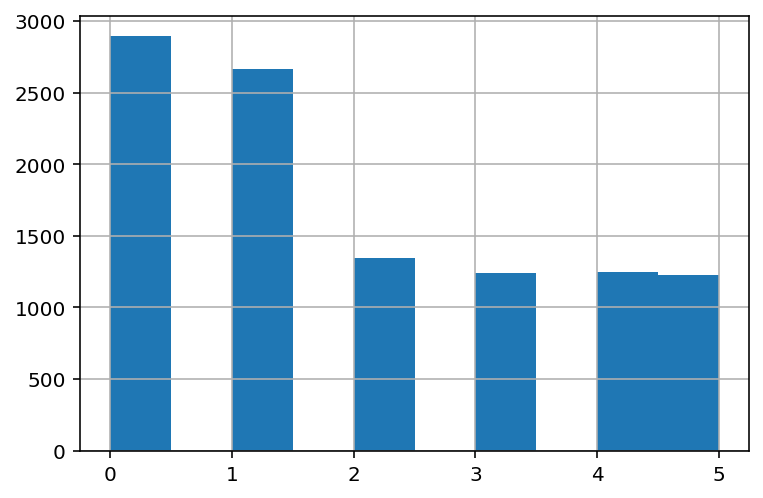

In [10]:
_ = TRAIN_DF[CFG.target_col].hist()

### Train Eval Loop

In [11]:
def train_eval_loop(train_dataset, val_dataset, model, optimizer, criterion, batch_sz=CFG.batch_size, num_epochs=CFG.epoch, tb_tag="", model_name="debug"):
    # Write first layer weights to TB
    if not CFG.debug:
        conv1_weight = model.conv1.weight.data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
        writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=0)
    
    # define a data loader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True, num_workers=8)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=False, num_workers=8)
    model.to(device)
    if CFG.use_amp:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
#     scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    # Define epochs numbers to look into input images and predictions
    # No more than 10 times per full training
    vis_step = np.ceil(num_epochs/10).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    
    best_qwk = -100
    best_val_loss = np.inf
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('=' * 10)
        
        # Training Phase
        # Set training mode
        model.train();
        train_running_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []
        # create random step
        rand_step = np.random.randint(0, len(train_dataloader))
        
        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step
            train_global_step = epoch * len(train_dataloader) + i
            
            inputs, labels = data
            # Visualize input to the model:
            if epoch in visual_epochs and i == rand_step:
                img = reverse_show_img(inputs[0])
                writer.add_image(tag=f"Input Image {tb_tag}", img_tensor=img, global_step=train_global_step, dataformats="HWC")
                del img
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            optimizer.step()
            # loss is mean across batch, multiply by batch size
            # divide by number of steps in epoch (so loss is normalized)
            train_running_loss += loss.item() / len(train_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Training loss {tb_tag}", scalar_value=loss.item(), global_step=train_global_step)
            
            # collect train preds and labels for QWK
            train_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            train_epoch_labels.append(labels.to('cpu').numpy())
        
        # Validation Phase
        # Set evaluation mode
        model.eval();
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Validation loss {tb_tag}", scalar_value=loss.item(), global_step=val_global_step)
            
            # collect validation preds and labels for QWK
            val_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            val_epoch_labels.append(labels.to('cpu').numpy())
            
            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                writer.add_figure(tag=f"Actuals vs Predictions {tb_tag}", figure=plot_classes_preds(outputs.to('cpu'), inputs.to('cpu'), labels.to('cpu')), 
                                  global_step=val_global_step)
        
        # Schedulers
        scheduler.step(val_running_loss)
        # Write lr to TBD
        writer.add_scalar(tag=f"lr {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
        
        # "End of Epoch" Phase
        print(f'Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}')
        
        # Calculate epoch QWK and preds distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        print(f'Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}')
        
        train_qwk = cohen_kappa_score(train_epoch_preds, train_epoch_labels, weights='quadratic')
        val_qwk = cohen_kappa_score(val_epoch_preds, val_epoch_labels, weights='quadratic')
        print(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch)
        writer.add_scalar(tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch)
        
        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            print(f'  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model')
            torch.save(model.state_dict(), f'{MODEL_PATH}/{model_name}_loss.pth')
            
            # add losses as text to TB
            writer.add_text("On save:", 
                            f"tr_loss: {train_running_loss:.4f}, tr_qwk: {train_qwk:.4f}, val_loss: {val_running_loss:.4f}, val_qwk: {val_qwk:.4f}",
                            global_step=val_global_step)
            
            # add image of conv1 weights to TB
            if not CFG.debug:
                conv1_weight = model.conv1.weight.data.to("cpu")
                img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
                writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=val_global_step)
            
            # add confusion matrix to TB
            writer.add_figure(tag=f"Confusion matrix {tb_tag}", figure=plot_confusion_matrix(val_epoch_labels, val_epoch_preds), 
                                  global_step=val_global_step)
        # On the best QWK
        if val_qwk > best_qwk:
            # update best and save model
            best_qwk = val_qwk
            print(f'  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model')
            torch.save(model.state_dict(), f'{MODEL_PATH}/{model_name}_qwk.pth')
            
            # add losses and qwk as text to TB
            writer.add_text("On save:", 
                            f"tr_loss: {train_running_loss:.4f}, tr_qwk: {train_qwk:.4f}, val_loss: {val_running_loss:.4f}, val_qwk: {val_qwk:.4f}",
                            global_step=val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                conv1_weight = model.conv1.weight.data.to("cpu")
                img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
                writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=val_global_step)
            
            # add confusion matrix to TB
            writer.add_figure(tag=f"Confusion matrix {tb_tag}", figure=plot_confusion_matrix(val_epoch_labels, val_epoch_preds), 
                                  global_step=val_global_step)
    
    writer.close()

### Prepare CV - strategy

In [12]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=100, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [13]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

In [14]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
 4   fold           10616 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 414.8+ KB


### Debug Runs

In [14]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/debug')

In [15]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [16]:
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train"), debug=False)
val_ds = LazyTilesDataset(val_df, transform=get_transforms(data="valid"), debug=False)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
train_eval_loop(train_ds, val_ds, model_ft, optimizer, criterion, num_epochs=10)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/9


100%|██████████| 166/166 [00:15<00:00, 10.68it/s]


Training Loss: 1.3295	Validation Loss: 1.1828
Counter train preds: Counter({0: 3139, 1: 2181, 5: 989, 4: 583, 3: 578, 2: 492})	Counter val preds: Counter({0: 988, 1: 803, 2: 264, 4: 249, 3: 189, 5: 161})
Epoch train QWK: 0.592	val QWK: 0.679
  Epoch 0 - Save Best Loss: 1.1828 Model
Confusion matrix, without normalization
[[633  78   2   1   5   4]
 [192 423  36   5   8   2]
 [ 39 187  84  15   9   1]
 [ 40  61  82  81  31  16]
 [ 44  42  32  39 126  30]
 [ 40  12  28  48  70 108]]
  Epoch 0 - Save Best QWK: 0.6792 Model
Confusion matrix, without normalization
[[633  78   2   1   5   4]
 [192 423  36   5   8   2]
 [ 39 187  84  15   9   1]
 [ 40  61  82  81  31  16]
 [ 44  42  32  39 126  30]
 [ 40  12  28  48  70 108]]
Epoch 1/9


100%|██████████| 166/166 [00:15<00:00, 10.57it/s]


Training Loss: 1.2105	Validation Loss: 1.1365
Counter train preds: Counter({0: 2998, 1: 2131, 5: 939, 3: 666, 4: 648, 2: 580})	Counter val preds: Counter({0: 1220, 5: 408, 1: 401, 2: 258, 3: 195, 4: 172})
Epoch train QWK: 0.665	val QWK: 0.708
  Epoch 1 - Save Best Loss: 1.1365 Model
Confusion matrix, without normalization
[[695  11   3   1   7   6]
 [285 264  88  14  14   1]
 [ 75  79 113  46  14   8]
 [ 60  23  33  85  28  82]
 [ 63  20  13  27  82 108]
 [ 42   4   8  22  27 203]]
  Epoch 1 - Save Best QWK: 0.7078 Model
Confusion matrix, without normalization
[[695  11   3   1   7   6]
 [285 264  88  14  14   1]
 [ 75  79 113  46  14   8]
 [ 60  23  33  85  28  82]
 [ 63  20  13  27  82 108]
 [ 42   4   8  22  27 203]]
Epoch 2/9


100%|██████████| 166/166 [00:16<00:00,  9.90it/s]


Training Loss: 1.1466	Validation Loss: 1.0919
Counter train preds: Counter({0: 2957, 1: 2043, 5: 921, 4: 718, 2: 685, 3: 638})	Counter val preds: Counter({0: 1004, 1: 684, 5: 488, 3: 237, 2: 128, 4: 113})
Epoch train QWK: 0.697	val QWK: 0.736
  Epoch 2 - Save Best Loss: 1.0919 Model
Confusion matrix, without normalization
[[666  46   1   2   1   7]
 [175 429  27  17   7  11]
 [ 39 140  69  53  11  23]
 [ 49  35  14  97  17  99]
 [ 37  30  11  46  60 129]
 [ 38   4   6  22  17 219]]
  Epoch 2 - Save Best QWK: 0.7355 Model
Confusion matrix, without normalization
[[666  46   1   2   1   7]
 [175 429  27  17   7  11]
 [ 39 140  69  53  11  23]
 [ 49  35  14  97  17  99]
 [ 37  30  11  46  60 129]
 [ 38   4   6  22  17 219]]
Epoch 3/9


100%|██████████| 166/166 [00:15<00:00, 10.64it/s]


Training Loss: 1.1210	Validation Loss: 1.0817
Counter train preds: Counter({0: 2903, 1: 2082, 5: 939, 3: 737, 4: 693, 2: 608})	Counter val preds: Counter({1: 914, 0: 747, 3: 288, 4: 270, 5: 269, 2: 166})
Epoch train QWK: 0.715	val QWK: 0.763
  Epoch 3 - Save Best Loss: 1.0817 Model
Confusion matrix, without normalization
[[546 164   3   3   4   3]
 [109 486  49  13   9   0]
 [ 18 154  77  71  10   5]
 [ 28  47  23 126  52  35]
 [ 20  50  10  47 133  53]
 [ 26  13   4  28  62 173]]
  Epoch 3 - Save Best QWK: 0.7634 Model
Confusion matrix, without normalization
[[546 164   3   3   4   3]
 [109 486  49  13   9   0]
 [ 18 154  77  71  10   5]
 [ 28  47  23 126  52  35]
 [ 20  50  10  47 133  53]
 [ 26  13   4  28  62 173]]
Epoch 4/9


100%|██████████| 166/166 [00:15<00:00, 10.83it/s]


Training Loss: 1.0793	Validation Loss: 1.0670
Counter train preds: Counter({0: 2850, 1: 2100, 5: 960, 4: 693, 2: 681, 3: 678})	Counter val preds: Counter({0: 1062, 1: 625, 4: 373, 5: 257, 3: 212, 2: 125})
Epoch train QWK: 0.734	val QWK: 0.752
  Epoch 4 - Save Best Loss: 1.0670 Model
Confusion matrix, without normalization
[[687  22   0   3   8   3]
 [213 390  28  18  17   0]
 [ 47 152  57  51  25   3]
 [ 44  31  22  84  95  35]
 [ 38  23   9  36 159  48]
 [ 33   7   9  20  69 168]]
Epoch 5/9


 30%|███       | 150/498 [00:44<01:39,  3.49it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 166/166 [00:15<00:00, 10.66it/s]


Training Loss: 1.0708	Validation Loss: 1.0582
Counter train preds: Counter({0: 2866, 1: 2091, 5: 912, 3: 748, 4: 722, 2: 623})	Counter val preds: Counter({0: 905, 1: 840, 3: 358, 2: 213, 4: 176, 5: 162})
Epoch train QWK: 0.738	val QWK: 0.714
  Epoch 5 - Save Best Loss: 1.0582 Model
Confusion matrix, without normalization
[[636  72   1   5   4   5]
 [141 488  17  16   2   2]
 [ 26 193  85  26   2   3]
 [ 37  38  66 142  12  16]
 [ 32  39  26  88 103  25]
 [ 33  10  18  81  53 111]]
Epoch 6/9


100%|██████████| 166/166 [00:15<00:00, 10.41it/s]

Training Loss: 1.0294	Validation Loss: 1.0607
Counter train preds: Counter({0: 2787, 1: 2104, 5: 935, 3: 761, 4: 716, 2: 659})	Counter val preds: Counter({0: 888, 1: 854, 3: 280, 5: 254, 2: 232, 4: 146})
Epoch train QWK: 0.752	val QWK: 0.742
Epoch 7/9



100%|██████████| 166/166 [00:15<00:00, 10.74it/s]

Training Loss: 1.0140	Validation Loss: 1.1763
Counter train preds: Counter({0: 2767, 1: 2091, 5: 933, 4: 744, 3: 714, 2: 713})	Counter val preds: Counter({0: 1122, 1: 404, 4: 403, 5: 337, 2: 227, 3: 161})
Epoch train QWK: 0.769	val QWK: 0.735
Epoch 8/9



100%|██████████| 166/166 [00:17<00:00,  9.61it/s]

Epoch     9: reducing learning rate of group 0 to 5.0000e-05.
Training Loss: 0.9926	Validation Loss: 1.0619
Counter train preds: Counter({0: 2760, 1: 2079, 5: 929, 4: 753, 3: 739, 2: 702})	Counter val preds: Counter({0: 930, 1: 722, 4: 346, 5: 252, 2: 207, 3: 197})
Epoch train QWK: 0.775	val QWK: 0.753
Epoch 9/9



100%|██████████| 166/166 [00:15<00:00, 10.74it/s]


Training Loss: 0.9339	Validation Loss: 1.0145
Counter train preds: Counter({0: 2693, 1: 2064, 5: 907, 3: 791, 4: 777, 2: 730})	Counter val preds: Counter({0: 921, 1: 774, 5: 352, 2: 204, 3: 203, 4: 200})
Epoch train QWK: 0.789	val QWK: 0.763
  Epoch 9 - Save Best Loss: 1.0145 Model
Confusion matrix, without normalization
[[652  57   0   2   3   9]
 [155 461  31  10   5   4]
 [ 26 178  90  25   8   8]
 [ 29  38  54  92  29  69]
 [ 35  32  20  50 108  68]
 [ 24   8   9  24  47 194]]


### Experiment Run

In [15]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False use_amp: True img_height: 512 img_width: 512 lr: 0.0001 batch_size: 16 epoch: 50 seed: 1982 target_size: 6 img_id_col: image_id target_col: isup_grade n_fold: 4 tiff_layer: 1


In [16]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [17]:
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
train_ds = TilesTrainDataset(train_df, is_train=True, transform=get_transforms(data="train"), debug=False)
val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
train_eval_loop(train_ds, val_ds, model_ft, optimizer, criterion, model_name=EXP_NAME)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/49


100%|██████████| 166/166 [01:38<00:00,  1.68it/s]


Training Loss: 1.2682	Validation Loss: 1.1733
Counter train preds: Counter({0: 3077, 1: 2151, 5: 909, 4: 675, 3: 628, 2: 522})	Counter val preds: Counter({0: 1047, 1: 903, 3: 259, 5: 231, 4: 107, 2: 107})
Epoch train QWK: 0.619	val QWK: 0.649
  Epoch 0 - Save Best Loss: 1.1733 Model
Confusion matrix, without normalization
[[644  76   0   0   0   3]
 [185 469   8   2   1   1]
 [ 51 214  42  23   1   4]
 [ 52  73  38 111   5  32]
 [ 61  51  10  63  72  56]
 [ 54  20   9  60  28 135]]
  Epoch 0 - Save Best QWK: 0.6487 Model
Confusion matrix, without normalization
[[644  76   0   0   0   3]
 [185 469   8   2   1   1]
 [ 51 214  42  23   1   4]
 [ 52  73  38 111   5  32]
 [ 61  51  10  63  72  56]
 [ 54  20   9  60  28 135]]
Epoch 1/49


100%|██████████| 166/166 [01:39<00:00,  1.67it/s]


Training Loss: 1.1346	Validation Loss: 1.0746
Counter train preds: Counter({0: 2840, 1: 2193, 5: 939, 3: 687, 4: 674, 2: 629})	Counter val preds: Counter({0: 828, 1: 604, 2: 480, 5: 427, 4: 176, 3: 139})
Epoch train QWK: 0.702	val QWK: 0.748
  Epoch 1 - Save Best Loss: 1.0746 Model
Confusion matrix, without normalization
[[607  92   3   1   8  12]
 [115 360 174   8   5   4]
 [ 21  87 191  15   7  14]
 [ 30  30  72  66  25  88]
 [ 27  24  24  37  99 102]
 [ 28  11  16  12  32 207]]
  Epoch 1 - Save Best QWK: 0.7477 Model
Confusion matrix, without normalization
[[607  92   3   1   8  12]
 [115 360 174   8   5   4]
 [ 21  87 191  15   7  14]
 [ 30  30  72  66  25  88]
 [ 27  24  24  37  99 102]
 [ 28  11  16  12  32 207]]
Epoch 2/49


100%|██████████| 166/166 [01:45<00:00,  1.57it/s]


Training Loss: 1.0957	Validation Loss: 1.0593
Counter train preds: Counter({0: 2828, 1: 2126, 5: 874, 4: 769, 2: 693, 3: 672})	Counter val preds: Counter({0: 826, 1: 748, 5: 543, 3: 201, 2: 196, 4: 140})
Epoch train QWK: 0.711	val QWK: 0.756
  Epoch 2 - Save Best Loss: 1.0593 Model
Confusion matrix, without normalization
[[614  92   1   0  10   6]
 [106 459  70  17   3  11]
 [ 20 125  90  49  12  39]
 [ 35  31  24  87  11 123]
 [ 24  30   8  35  83 133]
 [ 27  11   3  13  21 231]]
  Epoch 2 - Save Best QWK: 0.7559 Model
Confusion matrix, without normalization
[[614  92   1   0  10   6]
 [106 459  70  17   3  11]
 [ 20 125  90  49  12  39]
 [ 35  31  24  87  11 123]
 [ 24  30   8  35  83 133]
 [ 27  11   3  13  21 231]]
Epoch 3/49


100%|██████████| 166/166 [01:40<00:00,  1.66it/s]


Training Loss: 1.0589	Validation Loss: 1.0040
Counter train preds: Counter({0: 2778, 1: 2159, 5: 892, 3: 749, 4: 745, 2: 639})	Counter val preds: Counter({0: 814, 1: 778, 5: 433, 4: 233, 3: 218, 2: 178})
Epoch train QWK: 0.735	val QWK: 0.789
  Epoch 3 - Save Best Loss: 1.0040 Model
Confusion matrix, without normalization
[[621  87   2   1   8   4]
 [110 474  49  21   7   5]
 [ 19 138  92  58  15  13]
 [ 27  34  22  90  44  94]
 [ 17  33   9  30 125  99]
 [ 20  12   4  18  34 218]]
  Epoch 3 - Save Best QWK: 0.7893 Model
Confusion matrix, without normalization
[[621  87   2   1   8   4]
 [110 474  49  21   7   5]
 [ 19 138  92  58  15  13]
 [ 27  34  22  90  44  94]
 [ 17  33   9  30 125  99]
 [ 20  12   4  18  34 218]]
Epoch 4/49


 48%|████▊     | 237/498 [02:30<02:21,  1.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 166/166 [01:40<00:00,  1.64it/s]

Training Loss: 1.0402	Validation Loss: 1.0086
Counter train preds: Counter({0: 2737, 1: 2170, 5: 905, 2: 730, 4: 719, 3: 701})	Counter val preds: Counter({0: 907, 1: 697, 5: 384, 3: 285, 2: 194, 4: 187})
Epoch train QWK: 0.742	val QWK: 0.772
Epoch 5/49



100%|██████████| 166/166 [01:42<00:00,  1.62it/s]


Training Loss: 1.0190	Validation Loss: 0.9723
Counter train preds: Counter({0: 2698, 1: 2165, 5: 906, 3: 752, 4: 745, 2: 696})	Counter val preds: Counter({0: 881, 1: 771, 3: 319, 5: 238, 4: 224, 2: 221})
Epoch train QWK: 0.759	val QWK: 0.767
  Epoch 5 - Save Best Loss: 0.9723 Model
Confusion matrix, without normalization
[[654  60   2   2   3   2]
 [120 491  36  15   2   2]
 [ 19 148 118  36   7   7]
 [ 31  31  41 146  21  41]
 [ 27  32  16  65 126  47]
 [ 30   9   8  55  65 139]]
Epoch 6/49


100%|██████████| 166/166 [01:42<00:00,  1.61it/s]

Training Loss: 1.0054	Validation Loss: 1.0434
Counter train preds: Counter({0: 2704, 1: 2147, 5: 894, 4: 778, 2: 723, 3: 716})	Counter val preds: Counter({1: 951, 0: 758, 2: 332, 5: 328, 3: 209, 4: 76})
Epoch train QWK: 0.757	val QWK: 0.750
Epoch 7/49



100%|██████████| 166/166 [01:42<00:00,  1.62it/s]

Training Loss: 0.9919	Validation Loss: 1.0117
Counter train preds: Counter({0: 2663, 1: 2153, 5: 890, 4: 791, 3: 761, 2: 704})	Counter val preds: Counter({0: 932, 1: 672, 2: 375, 5: 316, 4: 209, 3: 150})
Epoch train QWK: 0.764	val QWK: 0.771
Epoch 8/49



 60%|█████▉    | 297/498 [03:09<01:14,  2.71it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 166/166 [01:39<00:00,  1.67it/s]


Training Loss: 0.9727	Validation Loss: 0.9679
Counter train preds: Counter({0: 2664, 1: 2136, 5: 916, 4: 775, 2: 743, 3: 728})	Counter val preds: Counter({0: 902, 1: 738, 4: 298, 3: 278, 5: 268, 2: 170})
Epoch train QWK: 0.770	val QWK: 0.794
  Epoch 8 - Save Best Loss: 0.9679 Model
Confusion matrix, without normalization
[[666  45   1   1   8   2]
 [134 489  26  10   7   0]
 [ 23 142  98  54  13   5]
 [ 29  29  25 143  39  46]
 [ 24  25  11  43 163  47]
 [ 26   8   9  27  68 168]]
  Epoch 8 - Save Best QWK: 0.7937 Model
Confusion matrix, without normalization
[[666  45   1   1   8   2]
 [134 489  26  10   7   0]
 [ 23 142  98  54  13   5]
 [ 29  29  25 143  39  46]
 [ 24  25  11  43 163  47]
 [ 26   8   9  27  68 168]]
Epoch 9/49


100%|██████████| 166/166 [01:39<00:00,  1.67it/s]

Training Loss: 0.9800	Validation Loss: 0.9977
Counter train preds: Counter({0: 2664, 1: 2138, 5: 896, 4: 813, 3: 727, 2: 724})	Counter val preds: Counter({1: 925, 0: 789, 5: 346, 3: 273, 2: 215, 4: 106})
Epoch train QWK: 0.766	val QWK: 0.781
Epoch 10/49



100%|██████████| 166/166 [01:38<00:00,  1.68it/s]


Training Loss: 0.9444	Validation Loss: 0.9629
Counter train preds: Counter({0: 2611, 1: 2186, 5: 898, 4: 786, 2: 743, 3: 738})	Counter val preds: Counter({0: 841, 1: 696, 3: 362, 5: 335, 2: 212, 4: 208})
Epoch train QWK: 0.786	val QWK: 0.797
  Epoch 10 - Save Best Loss: 0.9629 Model
Confusion matrix, without normalization
[[647  65   1   6   2   2]
 [100 467  65  27   5   2]
 [ 17 122 108  60  13  15]
 [ 29  19  25 155  26  57]
 [ 25  18  10  70 121  69]
 [ 23   5   3  44  41 190]]
  Epoch 10 - Save Best QWK: 0.7974 Model
Confusion matrix, without normalization
[[647  65   1   6   2   2]
 [100 467  65  27   5   2]
 [ 17 122 108  60  13  15]
 [ 29  19  25 155  26  57]
 [ 25  18  10  70 121  69]
 [ 23   5   3  44  41 190]]
Epoch 11/49


100%|██████████| 166/166 [01:38<00:00,  1.69it/s]

Training Loss: 0.9464	Validation Loss: 1.0399
Counter train preds: Counter({0: 2639, 1: 2107, 5: 893, 4: 801, 2: 765, 3: 757})	Counter val preds: Counter({0: 873, 1: 570, 3: 433, 5: 430, 4: 253, 2: 95})
Epoch train QWK: 0.784	val QWK: 0.790
Epoch 12/49



 68%|██████▊   | 341/498 [03:26<01:07,  2.32it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 166/166 [01:38<00:00,  1.69it/s]

Training Loss: 0.9436	Validation Loss: 0.9990
Counter train preds: Counter({0: 2646, 1: 2148, 5: 878, 4: 798, 3: 755, 2: 737})	Counter val preds: Counter({0: 888, 1: 743, 3: 491, 5: 227, 2: 196, 4: 109})
Epoch train QWK: 0.780	val QWK: 0.764
Epoch 13/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.9163	Validation Loss: 0.9659
Counter train preds: Counter({0: 2614, 1: 2124, 5: 897, 4: 818, 3: 771, 2: 738})	Counter val preds: Counter({0: 888, 1: 830, 2: 269, 3: 264, 5: 257, 4: 146})
Epoch train QWK: 0.789	val QWK: 0.778
Epoch 14/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Epoch    15: reducing learning rate of group 0 to 5.0000e-05.
Training Loss: 0.9136	Validation Loss: 0.9840
Counter train preds: Counter({0: 2606, 1: 2124, 5: 884, 4: 817, 2: 771, 3: 760})	Counter val preds: Counter({1: 910, 0: 751, 5: 413, 4: 243, 2: 194, 3: 143})
Epoch train QWK: 0.794	val QWK: 0.787
Epoch 15/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]


Training Loss: 0.8502	Validation Loss: 0.9008
Counter train preds: Counter({0: 2608, 1: 2107, 5: 898, 4: 821, 2: 811, 3: 717})	Counter val preds: Counter({0: 838, 1: 754, 5: 322, 3: 300, 4: 229, 2: 211})
Epoch train QWK: 0.814	val QWK: 0.811
  Epoch 15 - Save Best Loss: 0.9008 Model
Confusion matrix, without normalization
[[658  57   1   6   1   0]
 [103 499  34  22   3   5]
 [ 11 142 119  39  15   9]
 [ 27  27  32 135  44  46]
 [ 17  22  18  60 132  64]
 [ 22   7   7  38  34 198]]
  Epoch 15 - Save Best QWK: 0.8109 Model
Confusion matrix, without normalization
[[658  57   1   6   1   0]
 [103 499  34  22   3   5]
 [ 11 142 119  39  15   9]
 [ 27  27  32 135  44  46]
 [ 17  22  18  60 132  64]
 [ 22   7   7  38  34 198]]
Epoch 16/49


 75%|███████▍  | 373/498 [03:50<01:08,  1.82it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 166/166 [01:37<00:00,  1.70it/s]


Training Loss: 0.8307	Validation Loss: 0.9067
Counter train preds: Counter({0: 2576, 1: 2121, 5: 882, 4: 834, 2: 792, 3: 757})	Counter val preds: Counter({1: 834, 0: 790, 5: 323, 2: 315, 3: 207, 4: 185})
Epoch train QWK: 0.828	val QWK: 0.819
  Epoch 16 - Save Best QWK: 0.8186 Model
Confusion matrix, without normalization
[[641  77   0   4   1   0]
 [ 86 533  28  11   3   5]
 [  9 155 148  11   5   7]
 [ 24  32  95 102  25  33]
 [ 14  28  29  47 123  72]
 [ 16   9  15  32  28 206]]
Epoch 17/49


 95%|█████████▍| 473/498 [04:51<00:19,  1.27it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.8066	Validation Loss: 0.9725
Counter train preds: Counter({0: 2529, 1: 2139, 5: 869, 4: 833, 2: 800, 3: 792})	Counter val preds: Counter({0: 821, 1: 664, 4: 379, 5: 379, 3: 236, 2: 175})
Epoch train QWK: 0.831	val QWK: 0.809
Epoch 18/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.8150	Validation Loss: 0.9031
Counter train preds: Counter({0: 2534, 1: 2097, 5: 887, 4: 842, 2: 823, 3: 779})	Counter val preds: Counter({0: 834, 1: 657, 5: 386, 2: 318, 3: 233, 4: 226})
Epoch train QWK: 0.831	val QWK: 0.815
Epoch 19/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Epoch    20: reducing learning rate of group 0 to 2.5000e-05.
Training Loss: 0.7934	Validation Loss: 0.9196
Counter train preds: Counter({0: 2529, 1: 2100, 5: 898, 4: 833, 2: 825, 3: 777})	Counter val preds: Counter({0: 812, 1: 658, 4: 336, 2: 302, 3: 275, 5: 271})
Epoch train QWK: 0.837	val QWK: 0.814
Epoch 20/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]


Training Loss: 0.7477	Validation Loss: 0.8812
Counter train preds: Counter({0: 2505, 1: 2060, 5: 893, 2: 879, 4: 852, 3: 773})	Counter val preds: Counter({0: 802, 1: 735, 5: 386, 2: 272, 4: 263, 3: 196})
Epoch train QWK: 0.846	val QWK: 0.828
  Epoch 20 - Save Best Loss: 0.8812 Model
Confusion matrix, without normalization
[[648  68   1   3   2   1]
 [ 89 489  61  15   7   5]
 [ 12 124 148  23  16  12]
 [ 19  27  40 106  56  63]
 [ 17  22  14  31 147  82]
 [ 17   5   8  18  35 223]]
  Epoch 20 - Save Best QWK: 0.8282 Model
Confusion matrix, without normalization
[[648  68   1   3   2   1]
 [ 89 489  61  15   7   5]
 [ 12 124 148  23  16  12]
 [ 19  27  40 106  56  63]
 [ 17  22  14  31 147  82]
 [ 17   5   8  18  35 223]]
Epoch 21/49


100%|██████████| 166/166 [01:37<00:00,  1.70it/s]


Training Loss: 0.7431	Validation Loss: 0.8997
Counter train preds: Counter({0: 2530, 1: 2066, 5: 888, 4: 863, 2: 808, 3: 807})	Counter val preds: Counter({0: 781, 1: 692, 2: 370, 5: 356, 4: 243, 3: 212})
Epoch train QWK: 0.847	val QWK: 0.832
  Epoch 21 - Save Best QWK: 0.8315 Model
Confusion matrix, without normalization
[[640  74   3   3   3   0]
 [ 81 466  97  17   2   3]
 [  9 102 180  21  13  10]
 [ 19  24  60 110  40  58]
 [ 16  21  19  40 153  64]
 [ 16   5  11  21  32 221]]
Epoch 22/49


 18%|█▊        | 89/498 [00:59<02:29,  2.74it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 166/166 [01:37<00:00,  1.69it/s]

Training Loss: 0.7308	Validation Loss: 0.9016
Counter train preds: Counter({0: 2503, 1: 2077, 5: 902, 4: 863, 2: 846, 3: 771})	Counter val preds: Counter({1: 785, 0: 755, 5: 439, 2: 269, 4: 208, 3: 198})
Epoch train QWK: 0.854	val QWK: 0.824
Epoch 23/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]


Training Loss: 0.7198	Validation Loss: 0.8691
Counter train preds: Counter({0: 2500, 1: 2086, 5: 904, 4: 856, 2: 819, 3: 797})	Counter val preds: Counter({0: 775, 1: 714, 4: 313, 5: 303, 2: 285, 3: 264})
Epoch train QWK: 0.860	val QWK: 0.841
  Epoch 23 - Save Best Loss: 0.8691 Model
Confusion matrix, without normalization
[[639  73   2   5   3   1]
 [ 80 493  58  26   5   4]
 [ 11 101 164  39  15   5]
 [ 16  23  41 133  62  36]
 [ 13  20  13  36 184  47]
 [ 16   4   7  25  44 210]]
  Epoch 23 - Save Best QWK: 0.8412 Model
Confusion matrix, without normalization
[[639  73   2   5   3   1]
 [ 80 493  58  26   5   4]
 [ 11 101 164  39  15   5]
 [ 16  23  41 133  62  36]
 [ 13  20  13  36 184  47]
 [ 16   4   7  25  44 210]]
Epoch 24/49


100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.7060	Validation Loss: 0.8811
Counter train preds: Counter({0: 2499, 1: 2074, 5: 880, 4: 868, 2: 830, 3: 811})	Counter val preds: Counter({1: 752, 0: 738, 5: 394, 2: 297, 4: 259, 3: 214})
Epoch train QWK: 0.862	val QWK: 0.828
Epoch 25/49



100%|██████████| 166/166 [01:38<00:00,  1.68it/s]

Training Loss: 0.7044	Validation Loss: 0.9029
Counter train preds: Counter({0: 2484, 1: 2063, 5: 897, 4: 871, 2: 847, 3: 800})	Counter val preds: Counter({1: 807, 0: 705, 3: 339, 5: 304, 4: 261, 2: 238})
Epoch train QWK: 0.857	val QWK: 0.833
Epoch 26/49



 27%|██▋       | 134/498 [01:27<04:24,  1.38it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 87%|████████▋ | 434/498 [04:25<00:28,  2.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 166/166 [01:38<00:00,  1.69it/s]

Training Loss: 0.6972	Validation Loss: 0.9076
Counter train preds: Counter({0: 2486, 1: 2081, 5: 904, 4: 837, 3: 832, 2: 822})	Counter val preds: Counter({0: 794, 1: 702, 5: 339, 2: 307, 3: 280, 4: 232})
Epoch train QWK: 0.863	val QWK: 0.822
Epoch 27/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Epoch    28: reducing learning rate of group 0 to 1.2500e-05.
Training Loss: 0.6910	Validation Loss: 0.9146
Counter train preds: Counter({0: 2443, 1: 2082, 5: 909, 2: 881, 4: 847, 3: 800})	Counter val preds: Counter({0: 794, 1: 740, 5: 348, 4: 295, 2: 261, 3: 216})
Epoch train QWK: 0.870	val QWK: 0.828
Epoch 28/49



100%|██████████| 166/166 [01:38<00:00,  1.69it/s]

Training Loss: 0.6610	Validation Loss: 0.9050
Counter train preds: Counter({0: 2440, 1: 2096, 4: 881, 5: 875, 2: 860, 3: 810})	Counter val preds: Counter({0: 784, 1: 716, 5: 379, 2: 285, 4: 247, 3: 243})
Epoch train QWK: 0.878	val QWK: 0.834
Epoch 29/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.6452	Validation Loss: 0.8964
Counter train preds: Counter({0: 2479, 1: 2046, 5: 884, 4: 878, 2: 863, 3: 812})	Counter val preds: Counter({0: 763, 1: 724, 5: 414, 2: 289, 4: 237, 3: 227})
Epoch train QWK: 0.881	val QWK: 0.826
Epoch 30/49



100%|██████████| 166/166 [01:38<00:00,  1.69it/s]

Training Loss: 0.6468	Validation Loss: 0.8720
Counter train preds: Counter({0: 2458, 1: 2050, 5: 884, 4: 860, 3: 856, 2: 854})	Counter val preds: Counter({0: 795, 1: 720, 5: 360, 2: 312, 4: 277, 3: 190})
Epoch train QWK: 0.875	val QWK: 0.835
Epoch 31/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Epoch    32: reducing learning rate of group 0 to 6.2500e-06.
Training Loss: 0.6430	Validation Loss: 0.8868
Counter train preds: Counter({0: 2486, 1: 2033, 5: 905, 4: 898, 2: 827, 3: 813})	Counter val preds: Counter({0: 798, 1: 680, 5: 321, 3: 319, 4: 284, 2: 252})
Epoch train QWK: 0.872	val QWK: 0.836
Epoch 32/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.6385	Validation Loss: 0.8813
Counter train preds: Counter({0: 2451, 1: 2072, 5: 868, 2: 861, 4: 859, 3: 851})	Counter val preds: Counter({1: 763, 0: 758, 5: 313, 4: 297, 2: 285, 3: 238})
Epoch train QWK: 0.877	val QWK: 0.834
Epoch 33/49



100%|██████████| 166/166 [01:37<00:00,  1.71it/s]

Training Loss: 0.6157	Validation Loss: 0.8950
Counter train preds: Counter({0: 2438, 1: 2067, 4: 899, 5: 864, 2: 858, 3: 836})	Counter val preds: Counter({0: 763, 1: 698, 5: 377, 2: 320, 4: 249, 3: 247})
Epoch train QWK: 0.874	val QWK: 0.832
Epoch 34/49



 91%|█████████ | 453/498 [04:39<00:24,  1.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 166/166 [01:37<00:00,  1.70it/s]


Training Loss: 0.6228	Validation Loss: 0.8766
Counter train preds: Counter({0: 2447, 1: 2023, 5: 905, 2: 900, 4: 865, 3: 822})	Counter val preds: Counter({0: 779, 1: 693, 5: 365, 2: 300, 4: 261, 3: 256})
Epoch train QWK: 0.881	val QWK: 0.844
  Epoch 34 - Save Best QWK: 0.8438 Model
Confusion matrix, without normalization
[[654  61   1   2   4   1]
 [ 77 480  75  21   7   6]
 [  8 107 163  33  12  12]
 [ 14  23  34 139  50  51]
 [ 13  18  18  39 162  63]
 [ 13   4   9  22  26 232]]
Epoch 35/49


 58%|█████▊    | 291/498 [03:02<01:45,  1.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 166/166 [01:38<00:00,  1.69it/s]

Epoch    36: reducing learning rate of group 0 to 3.1250e-06.
Training Loss: 0.6049	Validation Loss: 0.8868
Counter train preds: Counter({0: 2443, 1: 2039, 5: 888, 2: 872, 4: 872, 3: 848})	Counter val preds: Counter({0: 766, 1: 746, 5: 357, 2: 308, 4: 254, 3: 223})
Epoch train QWK: 0.889	val QWK: 0.838
Epoch 36/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]


Training Loss: 0.6106	Validation Loss: 0.8690
Counter train preds: Counter({0: 2436, 1: 2055, 5: 899, 4: 871, 2: 865, 3: 836})	Counter val preds: Counter({0: 802, 1: 715, 5: 313, 2: 309, 4: 269, 3: 246})
Epoch train QWK: 0.878	val QWK: 0.838
  Epoch 36 - Save Best Loss: 0.8690 Model
Confusion matrix, without normalization
[[661  54   1   2   3   2]
 [ 84 492  63  14   7   6]
 [  9 118 170  22  11   5]
 [ 17  27  44 141  49  33]
 [ 14  18  23  45 167  46]
 [ 17   6   8  22  32 221]]
Epoch 37/49


100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.5946	Validation Loss: 0.8803
Counter train preds: Counter({0: 2419, 1: 2070, 5: 913, 4: 872, 3: 845, 2: 843})	Counter val preds: Counter({0: 781, 1: 722, 3: 315, 2: 306, 5: 272, 4: 258})
Epoch train QWK: 0.887	val QWK: 0.832
Epoch 38/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.6059	Validation Loss: 0.8890
Counter train preds: Counter({0: 2430, 1: 2052, 5: 889, 4: 882, 2: 870, 3: 839})	Counter val preds: Counter({0: 772, 1: 749, 5: 325, 2: 285, 4: 276, 3: 247})
Epoch train QWK: 0.885	val QWK: 0.832
Epoch 39/49



100%|██████████| 166/166 [01:37<00:00,  1.71it/s]

Epoch    40: reducing learning rate of group 0 to 1.5625e-06.
Training Loss: 0.6047	Validation Loss: 0.8783
Counter train preds: Counter({0: 2431, 1: 2074, 4: 895, 5: 864, 2: 853, 3: 845})	Counter val preds: Counter({0: 766, 1: 720, 5: 321, 2: 307, 4: 299, 3: 241})
Epoch train QWK: 0.886	val QWK: 0.833
Epoch 40/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.5852	Validation Loss: 0.8760
Counter train preds: Counter({0: 2415, 1: 2065, 5: 913, 4: 882, 2: 859, 3: 828})	Counter val preds: Counter({0: 775, 1: 690, 5: 337, 2: 310, 4: 283, 3: 259})
Epoch train QWK: 0.893	val QWK: 0.834
Epoch 41/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.5887	Validation Loss: 0.8849
Counter train preds: Counter({0: 2434, 1: 2071, 5: 892, 4: 880, 2: 856, 3: 829})	Counter val preds: Counter({0: 763, 1: 681, 5: 348, 2: 340, 4: 264, 3: 258})
Epoch train QWK: 0.883	val QWK: 0.833
Epoch 42/49



 33%|███▎      | 162/498 [01:40<03:58,  1.41it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 166/166 [01:38<00:00,  1.69it/s]

Training Loss: 0.5850	Validation Loss: 0.8832
Counter train preds: Counter({0: 2436, 1: 2022, 5: 900, 4: 882, 2: 880, 3: 842})	Counter val preds: Counter({0: 755, 1: 740, 5: 342, 2: 292, 4: 275, 3: 250})
Epoch train QWK: 0.887	val QWK: 0.838
Epoch 43/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Epoch    44: reducing learning rate of group 0 to 7.8125e-07.
Training Loss: 0.5942	Validation Loss: 0.8818
Counter train preds: Counter({0: 2427, 1: 2047, 5: 891, 2: 889, 3: 866, 4: 842})	Counter val preds: Counter({0: 759, 1: 676, 5: 332, 2: 308, 4: 291, 3: 288})
Epoch train QWK: 0.893	val QWK: 0.833
Epoch 44/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.5897	Validation Loss: 0.8836
Counter train preds: Counter({0: 2431, 1: 2065, 5: 907, 4: 876, 2: 859, 3: 824})	Counter val preds: Counter({0: 781, 1: 687, 5: 361, 2: 324, 4: 254, 3: 247})
Epoch train QWK: 0.884	val QWK: 0.837
Epoch 45/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.5892	Validation Loss: 0.8814
Counter train preds: Counter({0: 2414, 1: 2082, 4: 902, 5: 893, 2: 859, 3: 812})	Counter val preds: Counter({0: 768, 1: 704, 5: 331, 2: 302, 4: 288, 3: 261})
Epoch train QWK: 0.890	val QWK: 0.838
Epoch 46/49



100%|██████████| 166/166 [01:38<00:00,  1.69it/s]

Training Loss: 0.5883	Validation Loss: 0.8743
Counter train preds: Counter({0: 2436, 1: 2045, 4: 887, 5: 880, 2: 869, 3: 845})	Counter val preds: Counter({0: 776, 1: 708, 5: 319, 4: 291, 2: 290, 3: 270})
Epoch train QWK: 0.891	val QWK: 0.835
Epoch 47/49



 46%|████▌     | 230/498 [02:22<01:43,  2.60it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 166/166 [01:37<00:00,  1.71it/s]

Epoch    48: reducing learning rate of group 0 to 3.9063e-07.
Training Loss: 0.5944	Validation Loss: 0.8851
Counter train preds: Counter({0: 2435, 1: 2028, 5: 900, 4: 882, 2: 867, 3: 850})	Counter val preds: Counter({0: 776, 1: 686, 5: 319, 2: 317, 4: 290, 3: 266})
Epoch train QWK: 0.890	val QWK: 0.836
Epoch 48/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]

Training Loss: 0.5905	Validation Loss: 0.8838
Counter train preds: Counter({0: 2456, 1: 2040, 5: 906, 4: 863, 2: 862, 3: 835})	Counter val preds: Counter({0: 779, 1: 707, 2: 313, 5: 310, 3: 290, 4: 255})
Epoch train QWK: 0.889	val QWK: 0.838
Epoch 49/49



100%|██████████| 166/166 [01:37<00:00,  1.70it/s]


Training Loss: 0.5830	Validation Loss: 0.8785
Counter train preds: Counter({0: 2430, 1: 2039, 4: 897, 2: 884, 5: 863, 3: 849})	Counter val preds: Counter({0: 775, 1: 732, 5: 338, 2: 288, 4: 264, 3: 257})
Epoch train QWK: 0.889	val QWK: 0.835


### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218
